# Starter Notebook for ***Interferometry***

#Part 0. Setup



First we setup our python libraries and create some helper routines

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Setup
import numpy as np
from astropy.io import fits
from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib 
plt.set_cmap("Reds")

#import scipy 
from scipy.ndimage import gaussian_filter
from scipy.ndimage import uniform_filter
from skimage.transform import resize
import scipy

import csv
from glob import glob
%matplotlib inline
rc('figure', figsize=(12.0, 6.0))


dir='/content/drive/MyDrive/vianie_ASTRO361/Lab 8 Interferometry/'


In [4]:
# This will do a fourier transform of an image. If you give a unit for the platescale 
# of the image, then it will return the fourier frequencies of the returned fourier transform
# for interferometry, image space is in radians and fourier space is (u,v) =  baseline/lambda.

def image2uvplane(image,unit=1.0 ):
  dimx,dimy=image.shape
  image=np.fft.fftshift(image)
  complex_visibility=np.fft.fftshift(np.fft.fft2(image/np.sum(image)))
  freq = np.fft.fftshift(np.fft.fftfreq(dimx, d=unit))
  return(complex_visibility,freq)

  ## the next routine will do an inverse Fourier Transform to go backwards.
def uvplane2image(cvis,unit=1.0 ):
  dimx,dimy=cvis.shape
  cvis=np.fft.fftshift(cvis)
  image=np.fft.fftshift(np.fft.ifft2(cvis))
  image=np.real(image)
  image=image/np.sum(image)
  freq = np.fft.fftshift(np.fft.fftfreq(dimx, d=unit))
  return(image,freq)

  ## the next routine will do an inverse Fourier Transform to go backwards.

In [5]:
# This will carry out an azimuthal average of a 2d image or visibility function
def radial_profile(data, center):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    navg=radialprofile.shape
    radii=np.arange(navg[0])
    return radialprofile,radii

In [6]:
# This will create circles or gaussians. Will be helpful for creating 
# artificial stars/binaries and (u,v) coverage
def create_circle(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

def create_gauss(h, w, center=None, sigma=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if sigma is None: # use the smallest distance between the center and image walls
        sigma = min(center[0], center[1], w-center[0], h-center[1])
    
    
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    gauss_image = np.exp(-.5*(dist_from_center/sigma)**2)
    return gauss_image


#Part 1. Comparing Results of a Direct Fourier Transform to an Analytic Result

In this section we will make a Fourier transform of an symmetric image and look at the visibility amplitudes. We can compare with the analytic results to see if we did it correctly.

Lets consider a gaussian in the image plane with a $\sigma = x$ radians.
Then the sigma in Fourier space is at "spatial frequency" $f=1/x$ in units cycles per radian.  In this section, lets change this a more tangible variable of $B$="Baseline (meters)" by assuming a wavelength $\lambda$: $B = f\lambda$

With the background, study carefully the code and results then work on the HW exercise in the instructions.

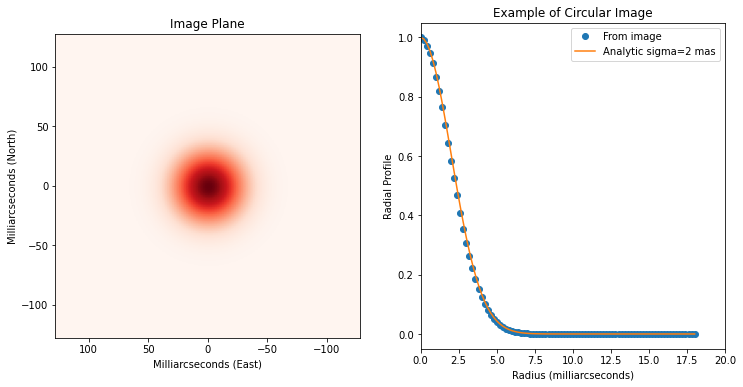

In [7]:
# First lets make an image with a sigma of 2 milli-arcseconds in an array with a platescale of 0.2 milliarcseconds per pixel.
# (remember that arcseconds/milliarcseconds are convenient units for astronomers, while when doing the Fourier transform we should think about units of radians).
dimx=128
platescale_mas=0.2 # milliarcseconds
platescale_radians = platescale_mas/1000/3600.*np.pi/180. # in RADIANS
sigma_mas=2 # mas
sigma_pix = sigma_mas/platescale_mas
fov_mas=sigma_mas*dimx


test_image=create_gauss(dimx,dimx,center=[dimx//2,dimx//2],sigma=sigma_pix)
test_profile,xvector_pix=radial_profile(test_image,[dimx//2,dimx//2])
xvector_mas=xvector_pix*platescale_mas
gauss_theory = np.exp(-.5*(xvector_mas/sigma_mas)**2)


plt.subplot(1,2,1)
plt.imshow(test_image,extent=[+fov_mas/2,-fov_mas/2,-fov_mas/2,+fov_mas/2])
plt.xlabel("Milliarcseconds (East)")
plt.ylabel("Milliarcseconds (North)")
plt.title("Image Plane")
#plt.imshow(test_image)
plt.subplot(1,2,2)
plt.plot(xvector_mas,test_profile,'o',label="From image")
plt.plot(xvector_mas,gauss_theory,label="Analytic sigma=2 mas")
plt.title("Example of Circular Image")
plt.xlabel("Radius (milliarcseconds)")
plt.ylabel("Radial Profile")
plt.xlim(0,20)
plt.legend();
plt.show()

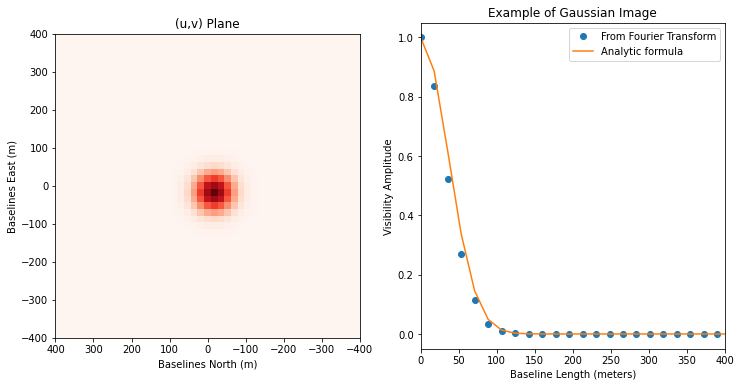

In [8]:
# Now we can take the Fourier Tranform of this image.  We call this the complex visibility function in the (u,v) plane (instead of x,y plane).
# As mentioned above, we can write the (u,v) plane here in terms of Baseline (m) since we are observing at a single
# wavelength.

# Lets assume wavelength is 2.2 microns to that the system resembles the CHARA Array.
wavelength=2.2e-6 # meters. 
cvis,freq=image2uvplane(test_image,unit=platescale_radians)
baselines = freq*wavelength # meters
visamp_avg,baseline_avg_pix = radial_profile(np.abs(cvis),[dimx//2,dimx//2])
baseline_avg = baseline_avg_pix* (baselines[1]-baselines[0]) # get units right.

sigma_radians =sigma_mas/1000./3600.*np.pi/180.

cvis_gauss_theory = np.exp(-.5*(2*np.pi*baseline_avg/wavelength/(1./sigma_radians))**2) 

maxb=baselines.max()
plt.subplot(1,2,1)
plt.imshow(np.abs(cvis),extent=[baselines.max(),baselines.min(),baselines.min(),baselines.max()])
plt.title("(u,v) Plane")
plt.xlabel("Baselines North (m)")
plt.ylabel("Baselines East (m)")
plt.xlim(400,-400)
plt.ylim(-400,400)
plt.subplot(1,2,2)
plt.plot(baseline_avg,visamp_avg,'o',label="From Fourier Transform")
plt.plot(baseline_avg,cvis_gauss_theory,label="Analytic formula")
plt.title("Example of Gaussian Image")
plt.xlabel("Baseline Length (meters)")
plt.ylabel("Visibility Amplitude")
plt.xlim(0,400)
plt.legend()
plt.show()

In [9]:
# Once you understand what is going on inthe code above, then move onto the first part of the assignment
# I encourage you to change around the parameters above (like platescale, sigma, wavelength) to test your understanding before moving on.

# Code for 1a can be put below.

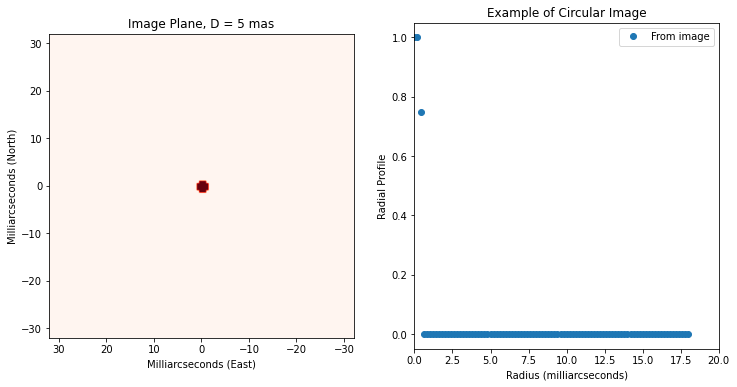

In [31]:
# First lets make an image with a sigma of 2 milli-arcseconds in an array with a platescale of 0.2 milliarcseconds per pixel.
# (remember that arcseconds/milliarcseconds are convenient units for astronomers, while when doing the Fourier transform we should think about units of radians).
dimx=128
platescale_mas=0.2 # milliarcseconds
platescale_radians = platescale_mas/1000/3600.*np.pi/180. # in RADIANS
sigma_mas= 0.5 # mas. # this is 1 and 5 for the homework 
sigma_pix = sigma_mas/platescale_mas
fov_mas=sigma_mas*dimx

### EDITS START HERE ###
#test_image=create_gauss(dimx,dimx,center=[dimx//2,dimx//2],sigma=sigma_pix)
test_image=create_circle(dimx,dimx,center=[dimx//2,dimx//2],radius=sigma_pix) #changed to circle from gaussian
test_profile,xvector_pix=radial_profile(test_image,[dimx//2,dimx//2])
xvector_mas=xvector_pix*platescale_mas
#gauss_theory = np.exp(-.5*(xvector_mas/sigma_mas)**2)
### EDITS END HERE ###

plt.subplot(1,2,1)
plt.imshow(test_image,extent=[+fov_mas/2,-fov_mas/2,-fov_mas/2,+fov_mas/2])
plt.xlabel("Milliarcseconds (East)")
plt.ylabel("Milliarcseconds (North)")
plt.title("Image Plane, D = 5 mas")
#plt.imshow(test_image)
plt.subplot(1,2,2)
plt.plot(xvector_mas,test_profile,'o',label="From image")
#plt.plot(xvector_mas,gauss_theory,label="Analytic sigma=2 mas")
plt.title("Example of Circular Image")
plt.xlabel("Radius (milliarcseconds)")
plt.ylabel("Radial Profile")
plt.xlim(0,20)
plt.legend();
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


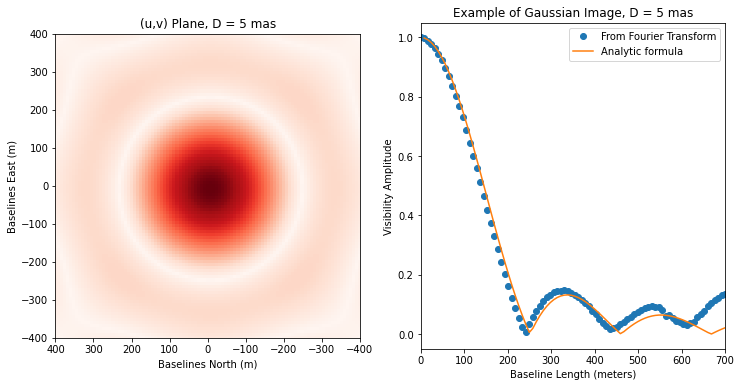

In [40]:
# Now we can take the Fourier Tranform of this image.  We call this the complex visibility function in the (u,v) plane (instead of x,y plane).
# As mentioned above, we can write the (u,v) plane here in terms of Baseline (m) since we are observing at a single
# wavelength.

# Lets assume wavelengtH is 2.2 microns to that the system resembles the CHARA Array.
wavelength=1.0e-6 # meters. #changed
cvis,freq=image2uvplane(test_image,unit=platescale_radians)
baselines = freq*wavelength # meters
visamp_avg,baseline_avg_pix = radial_profile(np.abs(cvis),[dimx//2,dimx//2])
baseline_avg = baseline_avg_pix* (baselines[1]-baselines[0]) # get units right.

sigma_radians =sigma_mas/1000./3600.*np.pi/180.

#cvis_gauss_theory = np.exp(-.5*(2*np.pi*baseline_avg/wavelength/(1./sigma_radians))**2) # change for part one (bessel)

### EDITS START HERE ###
a = sigma_radians * 2
s = baseline_avg/wavelength
J1 = scipy.special.jv(1.,np.pi*a*s)
cvis_bess_theory = np.abs((2*J1)/(np.pi*a*s)) 
### EDITS END HERE ###

maxb=baselines.max()
plt.subplot(1,2,1)
plt.imshow(np.abs(cvis),extent=[baselines.max(),baselines.min(),baselines.min(),baselines.max()])
plt.title("(u,v) Plane, D = 5 mas")
plt.xlabel("Baselines North (m)")
plt.ylabel("Baselines East (m)")
plt.xlim(400,-400)
plt.ylim(-400,400)
plt.subplot(1,2,2)
plt.plot(baseline_avg,visamp_avg,'o',label="From Fourier Transform")
plt.plot(baseline_avg,cvis_bess_theory,label="Analytic formula")
plt.title("Example of Gaussian Image, D = 5 mas")
plt.xlabel("Baseline Length (meters)")
plt.ylabel("Visibility Amplitude")
plt.xlim(0,700)
plt.legend()
plt.show()

#Part 2.  Interferometry Imaging

If you could measure all Fourier Components of an image then it would be trivial to reconstruct an image by doing an "inverse" Fourier Transform.   However, any realistic interferometer can only measure a finite number of visibility points.  Here we will see how changing the number of telescopes increases the number of instantaneous visibility points allowing better and better imaging.


In [12]:
#Before we start, we should write a helper routine that calculaates all the baselines you 
# have based on the locations of your telescopes: Note that really these are "projected"
# locations of the telescope from the point of view of an astronomical target.. or equivalently 
# if you object is straight overhead.

def tel2baselines (xcoord,ycoord):
  # loop over all telescope pairs and collect the baselines.
  N=len(xcoord)
  nbaselines = N*(N-1)//2
  baseline_x = np.zeros((nbaselines))
  baseline_y = np.zeros((nbaselines))
  counter=0
  for i in range(N-1):
    for j in range(i+1,N):
      baseline_x[counter]=xcoord[j]-xcoord[i]
      baseline_y[counter]=ycoord[j]-ycoord[i]
      counter = counter+1
  return(baseline_x,baseline_y)

## This routine will read in an image like jpg or png and convert to greyscale
def read_grayscale(file):
  an_image = matplotlib.image.imread(file)
  rgb_weights = [0.2989, 0.5870, 0.1140] # Rec. 601 Color Transform.
  grayscale_image = np. dot(an_image[...,: 3], rgb_weights)
  return(grayscale_image)

## This routine will create a mask in the uv plane based on baseline vector and a list of baseline coordinates.
def create_uvmask(baseline_vector,baseline_x,baseline_y):
  dimx=len(baseline_vector)
  mask=np.zeros((dimx,dimx))
  nbase=len(baseline_x)
  index_x= np.argmin( np.abs(baseline_vector))
  index_y= np.argmin( np.abs(baseline_vector))
  mask[index_x,index_y]=1
  for i in range(nbase):
    index_x= np.argmin( np.abs(baseline_vector-baseline_x[i]))
    index_y= np.argmin( np.abs(baseline_vector-baseline_y[i]))
    mask[index_x,index_y]=1
    index_x= np.argmin( np.abs(baseline_vector+baseline_x[i]))
    index_y= np.argmin( np.abs(baseline_vector+baseline_y[i]))
    mask[index_x,index_y]=1
  return(mask)


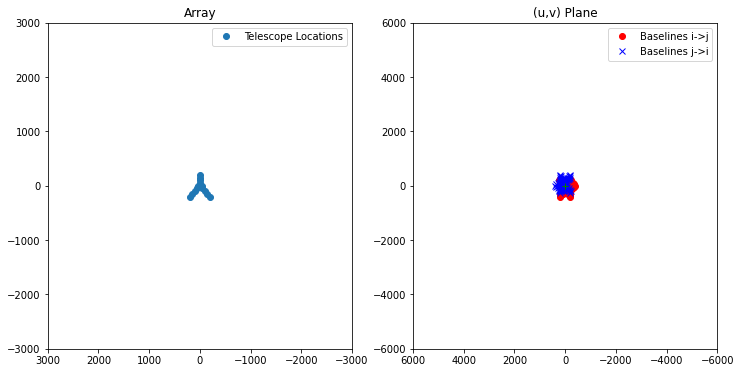

In [13]:
#lets create an array of N telescopes equally spaced around a ring with max baseline Bmax
# and choose a wavelength.  

N= 15
bmax= 5000. #meters ; like CHARA
wavelength = 1.65e-6 # meters
angles = np.linspace(0,2.*np.pi,N,endpoint=False)
xcoord =  [0, 0, 0, 200, 150, 100, 50, 0, -50, -100, -150, -200, 0, 40, -40]      # bmax/2*np.cos(angles)
ycoord =  [100, 150, 200, -200, -150, -100, -50, 0, -50, -100, -150, -200, 50, 0, 0]    # bmax/2*np.sin(angles)

# An interferometer measure a Fourier component for each baselines, so lets
# loop over all telescope pairs and collect the baselines.
nbaselines = N*(N-1)//2

baseline_x,baseline_y = tel2baselines(xcoord,ycoord)
plt.subplot(1,2,1)
plt.plot(xcoord,ycoord,'o',label="Telescope Locations")
plt.xlim(bmax*.6,-bmax*.6)
plt.ylim(-bmax*.6,+bmax*.6)
plt.title("Array")
plt.legend();
plt.subplot(1,2,2)

plt.plot(baseline_x,baseline_y,'ro',label="Baselines i->j")
plt.plot(-baseline_x,-baseline_y,'bx',label="Baselines j->i")
plt.plot(0,0,'g+')
plt.xlim(bmax*1.2,-bmax*1.2)
plt.ylim(-bmax*1.2,+bmax*1.2)
plt.title("(u,v) Plane")
plt.legend();

Text(0.5, 1.0, 'Complex Image')

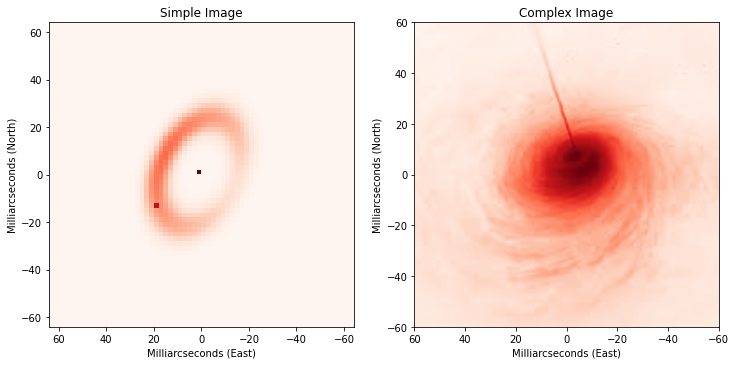

In [14]:
# in the abovel cell, you can adjust Bmax and N. You can see that a simple annulus pattern of equally space
# telescopes gives very "nice" and uniform (u,v) coverage.

# Now lets see how well this array performs for imaging a simple and a complex scence.
# for simple scene I will just contruct a random set of circles and gaussians and for
# complex I will load in a simulated image of the M87 black hole accretion disk with jet!
platescale_mas=0.25 # mas
platescale_radians = platescale_mas/1000/3600*np.pi/180.
simple_image =  .2*create_circle(512,512,center=[256,256],radius=10)
simple_image += .5*create_gauss(512,512,center=[300,256],sigma=20)
simple_image += .6*create_gauss(512,512,center=[220,306],sigma=50)
simple_image +=  1.25*create_circle(512,512,center=[220,160],radius=3)

dimx1,dimy1=simple_image.shape

m87_file = dir+'M87_simulation.png'
star_ring_file = dir+'Star_with_Dust_Ring.fits'

simple_image = fits.getdata(star_ring_file)

complex_image = read_grayscale(m87_file)
dimx2,dimy2=complex_image.shape
# make into square since my routine requires squares to be accurate.
dimx2=np.min([dimx2,dimy2])
complex_image=complex_image[:dimx2,:dimx2]
dimx2,dimy2=complex_image.shape

# show the images and the visibility amplitudes
fov_mas1=dimx1*platescale_mas
fov_mas2=dimx2*platescale_mas
plt.subplot(1,2,1)
plt.imshow(simple_image,extent=[+fov_mas1/2,-fov_mas1/2,-fov_mas1/2,+fov_mas1/2])
plt.xlabel("Milliarcseconds (East)")
plt.ylabel("Milliarcseconds (North)")
plt.title("Simple Image")
plt.subplot(1,2,2)
plt.imshow(complex_image,extent=[+fov_mas2/2,-fov_mas2/2,-fov_mas2/2,+fov_mas2/2])
plt.xlabel("Milliarcseconds (East)")
plt.ylabel("Milliarcseconds (North)")
plt.title("Complex Image")



In [15]:
# So lets next look at the visibility amplitudes. Recall the visibilites are complex numbers but we are only showing the 
# amplitudes. Also in Part 1, we shows the visibilities as a curve vs baseline.  For asymmetric objects, the visibilities
#  are 2-dimensional so I will show in 2d in the (u,v) plane

(-400.0, 400.0)

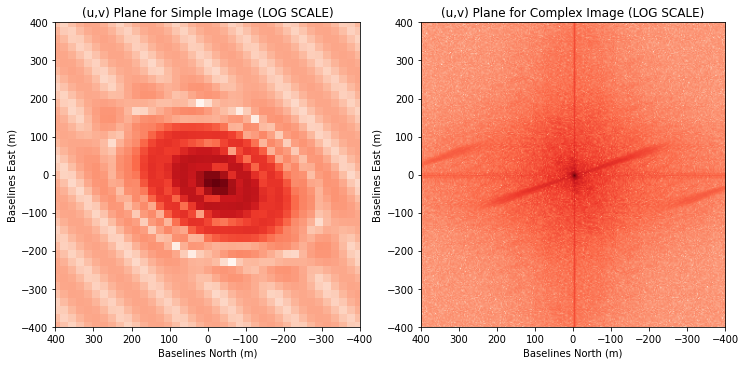

In [16]:

wavelength = 1.65e-6 # meters. 
cvis1,freq1=image2uvplane(simple_image,unit=platescale_radians)
baselines1 = freq1*wavelength # meters
cvis2,freq2=image2uvplane(complex_image,unit=platescale_radians)
baselines2 = freq2*wavelength # meters

plt.subplot(1,2,1)
plt.imshow(np.log10(np.abs(cvis1)),extent=[baselines1.max(),baselines1.min(),baselines1.min(),baselines1.max()])
plt.title("(u,v) Plane for Simple Image (LOG SCALE)")
plt.xlabel("Baselines North (m)")
plt.ylabel("Baselines East (m)")
plt.xlim(400,-400)
plt.ylim(-400,400)

plt.subplot(1,2,2)
plt.imshow(np.log10(np.abs(cvis2)),extent=[baselines2.max(),baselines2.min(),baselines2.min(),baselines2.max()])
plt.title("(u,v) Plane for Complex Image (LOG SCALE)")
plt.xlabel("Baselines North (m)")
plt.ylabel("Baselines East (m)")
plt.xlim(400,-400)
plt.ylim(-400,400)


(-400.0, 400.0)

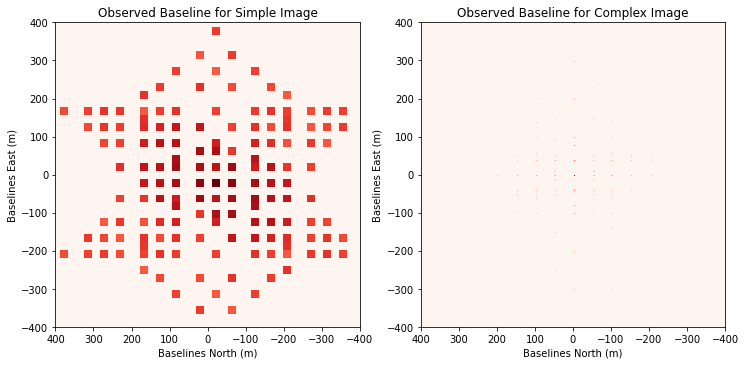

In [17]:
# With linear scale you can see that most of the visibilty signals are on short baselines < 50m
# but with logscale you can see more structure at longer baselines.

# Now we will "sample" the Fourier Plane only where we have data then do an inverse Fourier Transform 
# to create a "dirty map" and see how similar the 'dirty map is to the truth image.

# to do this we create a "mask" in the (u,v) plane that has a 1 where there is data and 0 where there is no data.  
# 
uvmask1= create_uvmask(baselines1,baseline_x,baseline_y)
uvmask2= create_uvmask(baselines2,baseline_x,baseline_y)

plt.subplot(1,2,1)
plt.imshow(np.log10(np.abs(cvis1*uvmask1)+1e-5),extent=[baselines1.max(),baselines1.min(),baselines1.min(),baselines1.max()])
plt.title("Observed Baseline for Simple Image")
plt.xlabel("Baselines North (m)")
plt.ylabel("Baselines East (m)")
plt.xlim(400,-400)
plt.ylim(-400,400)

plt.subplot(1,2,2)
plt.imshow(np.log10(np.abs(cvis2*uvmask2)+1e-5),extent=[baselines2.max(),baselines2.min(),baselines2.min(),baselines2.max()])
plt.title("Observed Baseline for Complex Image")
plt.xlabel("Baselines North (m)")
plt.ylabel("Baselines East (m)")
plt.xlim(400,-400)
plt.ylim(-400,400)


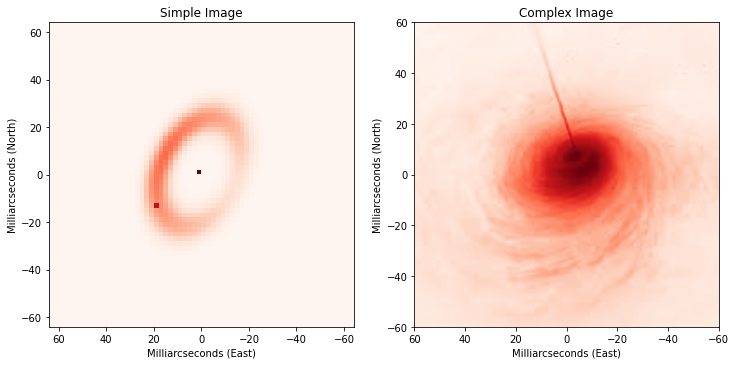

Text(0.5, 1.0, 'Complex Image')

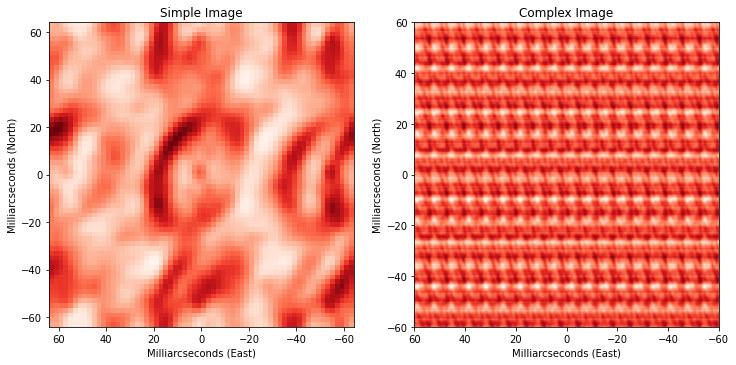

In [18]:
# now lets see how images compare
dirty_map1, x1= uvplane2image(cvis1*uvmask1)
dirty_map2, x2= uvplane2image(cvis2*uvmask2)

# show the images and the visibility amplitudes
fov_mas1=dimx1*platescale_mas
fov_mas2=dimx2*platescale_mas
plt.subplot(1,2,1)
plt.imshow(simple_image,extent=[+fov_mas1/2,-fov_mas1/2,-fov_mas1/2,+fov_mas1/2])
plt.xlabel("Milliarcseconds (East)")
plt.ylabel("Milliarcseconds (North)")
plt.title("Simple Image")
plt.subplot(1,2,2)
plt.imshow(complex_image,extent=[+fov_mas2/2,-fov_mas2/2,-fov_mas2/2,+fov_mas2/2])
plt.xlabel("Milliarcseconds (East)")
plt.ylabel("Milliarcseconds (North)")
plt.title("Complex Image")
plt.show()
# show the images and the visibility amplitudes
fov_mas1=dimx1*platescale_mas
fov_mas2=dimx2*platescale_mas
plt.subplot(1,2,1)
plt.imshow(dirty_map1,extent=[+fov_mas1/2,-fov_mas1/2,-fov_mas1/2,+fov_mas1/2])
plt.xlabel("Milliarcseconds (East)")
plt.ylabel("Milliarcseconds (North)")
plt.title("Simple Image")
plt.subplot(1,2,2)
plt.imshow(dirty_map2,extent=[+fov_mas2/2,-fov_mas2/2,-fov_mas2/2,+fov_mas2/2])
plt.xlabel("Milliarcseconds (East)")
plt.ylabel("Milliarcseconds (North)")
plt.title("Complex Image")




In [19]:
# If the images don't look good, then adjust the number of telescopes and the max baseline
# so that you better samplet the part of the uv plane that carries the most 'information"

# i found it was fun to change N and Bmax to see how the reconstructed imaes change!
# of If you only have LONG baselines you mainly see the small structures (star, jet) and
# if you have only short baseline then you see the smoother, more diffuse emissions (like from disk).



In [20]:
# After you have finished exploring the Part 2 code above, move onto the HW in the instructions parts 2abc.
# Here you will load in a different image and find a good 15-telescope array for imaging the disk+ring (+planet) structures.
# You can either use the "ring geometry" or can choose your own !!  e.g., try just randomn positions for your 15 telescopes
# within a certain box and see how good the imaging is.



#Part 3.  Imaging yourself with ALMA

You will applying the code from the last section to try to make an image of yourself with ALMA. Below is example code using a circular ring geometry from the last section, but for your HW uo will nee dto use yoru own image and load the positions of the 43 ALMA antennas from the file: alma.cycle6.10.cfg




Text(0.5, 1.0, 'Truth Image')

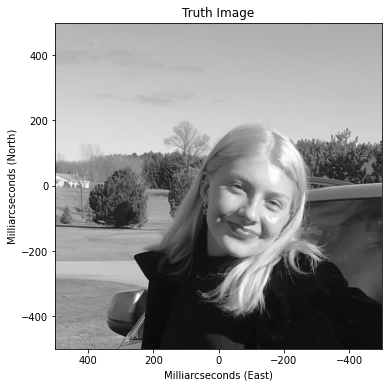

In [21]:
#Load in your selfie and make square.
#Set platescale
jdm_file = dir+'selfie.JPG'
selfie=read_grayscale(jdm_file)
#selfie=np.flip(selfie,axis=0) # flip right side up
dimx,dimy=selfie.shape
dimx=np.min([dimx,dimy])
selfie=selfie[:dimx,:dimx]
# resize to 512 to make the code more tractable
selfie=resize(selfie,(512,512))
dimx,dimy=selfie.shape
platescale_mas = 1000./dimx # milliarcseconds
platescale_radians= platescale_mas/1000/3600.*np.pi/180.
fov_mas= dimx*platescale_mas
plt.imshow(selfie,cmap='gray',extent=[+fov_mas/2,-fov_mas/2,-fov_mas/2,+fov_mas/2])
plt.xlabel("Milliarcseconds (East)");
plt.ylabel("Milliarcseconds (North)");
plt.title("Truth Image")


In [22]:
almx = np.loadtxt(dir + 'alma.cycle6.10.cfg', usecols = (0))
almy = np.loadtxt(dir + 'alma.cycle6.10.cfg', usecols = (1))

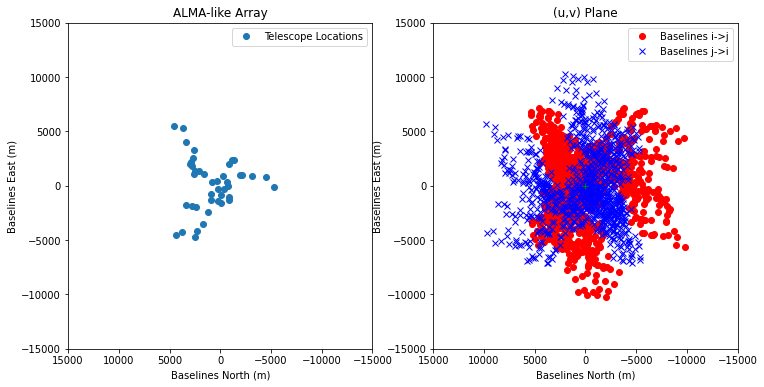

In [23]:
#For HW, you will reading in the ALMA positions instead of using the circular pattern.

N= 50
#bmax=5000. #meters ; like ALMA
wavelength = 1.3e-3 # meters 
angles = np.linspace(0,2.*np.pi,N,endpoint=False)
f = 0.7
xcoord = almx * f
ycoord = almy * f

# An interferometer measure a Fourier component for each baselines, so lets
# loop over all telescope pairs and collect the baselines.
nbaselines = N*(N-1)//2

baseline_x,baseline_y = tel2baselines(xcoord,ycoord)
plt.subplot(1,2,1)
plt.plot(xcoord,ycoord,'o',label="Telescope Locations")
plt.xlim(15000,-15000)
plt.ylim(-15000,15000)
plt.title("ALMA-like Array")
plt.xlabel("Baselines North (m)")
plt.ylabel("Baselines East (m)")
plt.legend();
plt.subplot(1,2,2)

plt.plot(baseline_x,baseline_y,'ro',label="Baselines i->j")
plt.plot(-baseline_x,-baseline_y,'bx',label="Baselines j->i")
plt.plot(0,0,'g+')
plt.xlim(15000,-15000)
plt.ylim(-15000,15000)
plt.title("(u,v) Plane")
plt.xlabel("Baselines North (m)")
plt.ylabel("Baselines East (m)")
plt.legend();

(-19669.319599999995, 19669.319599999995)

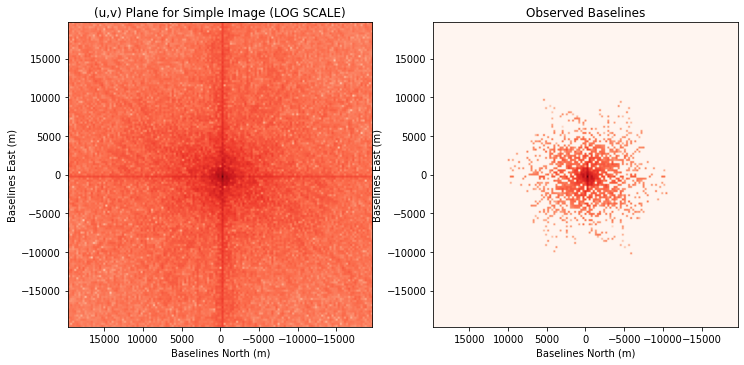

In [24]:

cvis,freq=image2uvplane(selfie,unit=platescale_radians)
baselines = freq*wavelength # meters

uvmask= create_uvmask(baselines,baseline_x,baseline_y)
maxbase=np.min([np.max([np.max(np.abs(baseline_x)), .1*max(np.abs(baselines))]),.5*max(np.abs(baselines))])
plt.subplot(1,2,1)
plt.imshow(np.log10(np.abs(cvis)),extent=[baselines.max(),baselines.min(),baselines.min(),baselines.max()])
plt.title("(u,v) Plane for Simple Image (LOG SCALE)")
plt.xlabel("Baselines North (m)")
plt.ylabel("Baselines East (m)")
plt.xlim(2*maxbase,-2*maxbase)
plt.ylim(-2*maxbase,2*maxbase)

plt.subplot(1,2,2)
plt.imshow(np.log10(np.abs(cvis*uvmask)+1e-5),extent=[baselines.max(),baselines.min(),baselines.min(),baselines.max()])
plt.title("Observed Baselines")
plt.xlabel("Baselines North (m)")
plt.ylabel("Baselines East (m)")
plt.xlim(2*maxbase,-2*maxbase)
plt.ylim(-2*maxbase,2*maxbase)

Text(0.5, 1.0, 'Reconstructed Image')

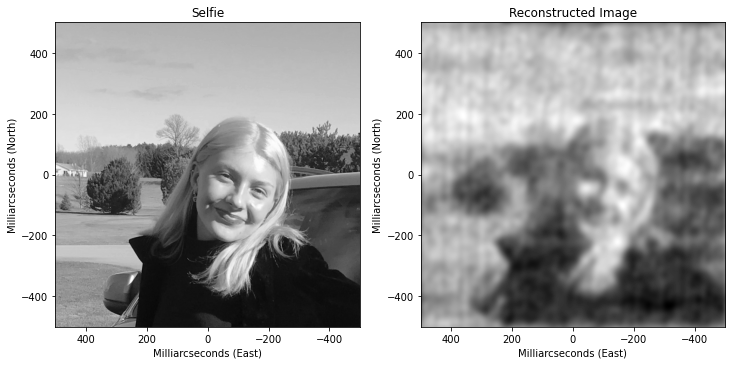

In [25]:
# now lets see how images compare
dirty_map, x= uvplane2image(cvis*uvmask)
fov_mas=dimx*platescale_mas

# show the images and the visibility amplitudes
fov_mas=dimx*platescale_mas
plt.subplot(1,2,1)
plt.imshow(selfie,cmap='gray',extent=[+fov_mas/2,-fov_mas/2,-fov_mas/2,+fov_mas/2])
plt.xlabel("Milliarcseconds (East)")
plt.ylabel("Milliarcseconds (North)")
plt.title("Selfie")

plt.subplot(1,2,2)
plt.imshow(dirty_map,cmap='gray',extent=[+fov_mas/2,-fov_mas/2,-fov_mas/2,+fov_mas/2])
plt.xlabel("Milliarcseconds (East)")
plt.ylabel("Milliarcseconds (North)")
plt.title("Reconstructed Image")

In [26]:
# Now your turn!  Try your own image using the ALMA coverage.  Which is better? ALMA coverage with 43 telescopes or my simple ring geometry?

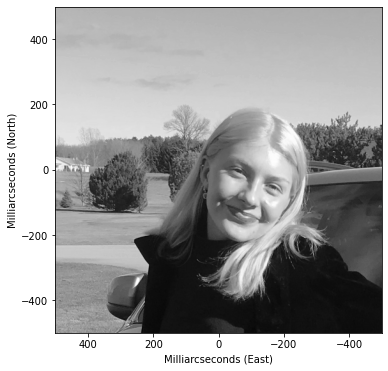

In [27]:
#Load in your selfie and make square.
#Set platescale
jdm_file = dir+'selfie.JPG'
selfie=read_grayscale(jdm_file)
#selfie=np.flip(selfie,axis=0) # flip right side up
dimx,dimy=selfie.shape
dimx=np.min([dimx,dimy])
selfie=selfie[:dimx,:dimx]
# resize to 512 to make the code more tractable
selfie=resize(selfie,(512,512))
dimx,dimy=selfie.shape
platescale_mas = 1000./dimx # milliarcseconds
platescale_radians= platescale_mas/1000/3600.*np.pi/180.
fov_mas= dimx*platescale_mas
plt.imshow(selfie,cmap='gray',extent=[+fov_mas/2,-fov_mas/2,-fov_mas/2,+fov_mas/2])
plt.xlabel("Milliarcseconds (East)");
plt.ylabel("Milliarcseconds (North)");


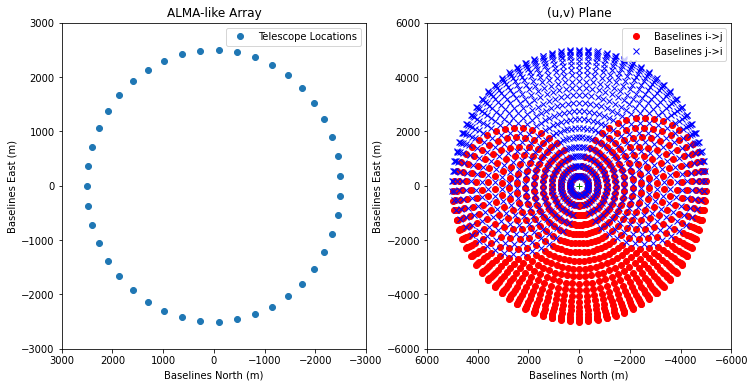

In [28]:
#For HW, you will reading in the ALMA positions instead of using the circular pattern.

N=43
bmax=5000. #meters ; like ALMA
wavelength = 1.3e-3 # meters 
angles = np.linspace(0,2.*np.pi,N,endpoint=False)
xcoord = bmax/2*np.cos(angles)
ycoord = bmax/2*np.sin(angles)

# An interferometer measure a Fourier component for each baselines, so lets
# loop over all telescope pairs and collect the baselines.
nbaselines = N*(N-1)//2

baseline_x,baseline_y = tel2baselines(xcoord,ycoord)
plt.subplot(1,2,1)
plt.plot(xcoord,ycoord,'o',label="Telescope Locations")
plt.xlim(bmax*.6,-bmax*.6)
plt.ylim(-bmax*.6,+bmax*.6)
plt.title("ALMA-like Array")
plt.xlabel("Baselines North (m)")
plt.ylabel("Baselines East (m)")
plt.legend();
plt.subplot(1,2,2)

plt.plot(baseline_x,baseline_y,'ro',label="Baselines i->j")
plt.plot(-baseline_x,-baseline_y,'bx',label="Baselines j->i")
plt.plot(0,0,'g+')
plt.xlim(bmax*1.2,-bmax*1.2)
plt.ylim(-bmax*1.2,+bmax*1.2)
plt.title("(u,v) Plane")
plt.xlabel("Baselines North (m)")
plt.ylabel("Baselines East (m)")
plt.legend();

(-13728.985503806733, 13728.985503806733)

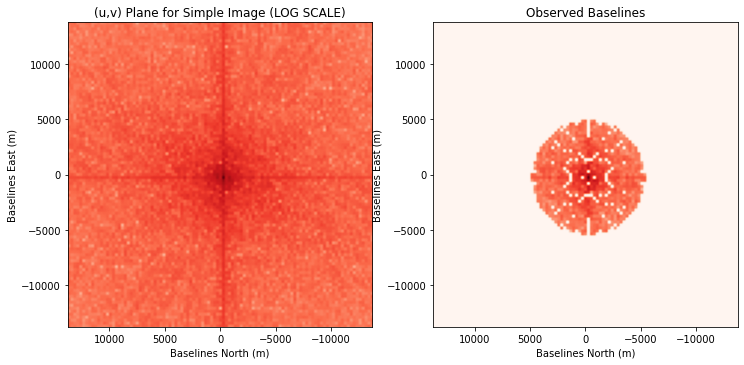

In [29]:
cvis,freq=image2uvplane(selfie,unit=platescale_radians)
baselines = freq*wavelength # meters

uvmask= create_uvmask(baselines,baseline_x,baseline_y)
maxbase=np.min([np.max([np.max(np.abs(baseline_x)), .1*max(np.abs(baselines))]),.5*max(np.abs(baselines))])
plt.subplot(1,2,1)
plt.imshow(np.log10(np.abs(cvis)),extent=[baselines.max(),baselines.min(),baselines.min(),baselines.max()])
plt.title("(u,v) Plane for Simple Image (LOG SCALE)")
plt.xlabel("Baselines North (m)")
plt.ylabel("Baselines East (m)")
plt.xlim(2*maxbase,-2*maxbase)
plt.ylim(-2*maxbase,2*maxbase)

plt.subplot(1,2,2)
plt.imshow(np.log10(np.abs(cvis*uvmask)+1e-5),extent=[baselines.max(),baselines.min(),baselines.min(),baselines.max()])
plt.title("Observed Baselines")
plt.xlabel("Baselines North (m)")
plt.ylabel("Baselines East (m)")
plt.xlim(2*maxbase,-2*maxbase)
plt.ylim(-2*maxbase,2*maxbase)

Text(0.5, 1.0, 'Reconstructed Image')

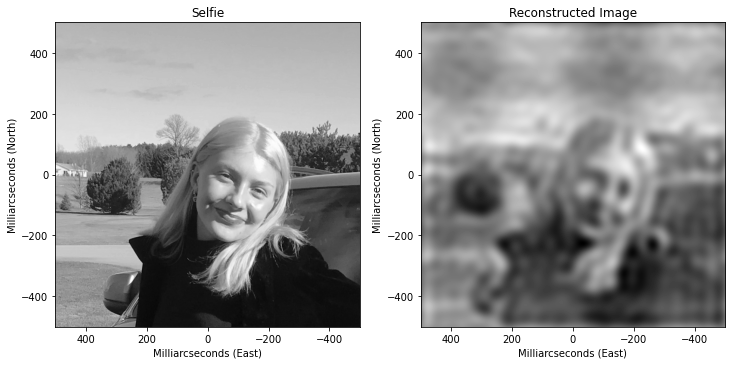

In [30]:
# now lets see how images compare
dirty_map, x= uvplane2image(cvis*uvmask)
fov_mas=dimx*platescale_mas

# show the images and the visibility amplitudes
fov_mas=dimx*platescale_mas
plt.subplot(1,2,1)
plt.imshow(selfie,cmap='gray',extent=[+fov_mas/2,-fov_mas/2,-fov_mas/2,+fov_mas/2])
plt.xlabel("Milliarcseconds (East)")
plt.ylabel("Milliarcseconds (North)")
plt.title("Selfie")

plt.subplot(1,2,2)
plt.imshow(dirty_map,cmap='gray',extent=[+fov_mas/2,-fov_mas/2,-fov_mas/2,+fov_mas/2])
plt.xlabel("Milliarcseconds (East)")
plt.ylabel("Milliarcseconds (North)")
plt.title("Reconstructed Image")

